In [1]:
import os

dataset_path = os.environ["DATA"] + "/00_datasets/DFT/QM9/QM9_smi_datasets/train_test_dataset_100000.smi"
json_cache_location = os.environ["DATA"] + "/00_datasets/DFT/QM9/cache_QM9.json"

output_results_path = os.environ["DATA"] + "/07_BBO/02_models/post_paper/01.01_GPR_HOMO_QM9/"
output_figures_path = os.environ["FIGURES"] + "/07_BBO/02_models/post_paper/01.01_GPR_HOMO_QM9/"

dft_path = os.environ["DFT_COMPUT_RDKIT_MM"]

TOTAL_DATASET_SIZE = 10000
N_MOL = 1000

CV_INTERNAL = 5
CV_EXTERNAL = 10

N_JOBS=55

ALPHAS = [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1]
ALPHAS_WHITEK = [1e-10]

WHITE_KERNEL = [True, False]
NORMALIZE_Y = [True, False]

MM_program = "rdkit"

# (Kernel, descritor, contains white kernel, normalize y)
models_to_run = [
    ("1.0*SOAP( xi=2)", "SOAP", False, True),
    ("1.0*SOAP( xi=2)", "SOAP", False, False),
    ("1.0*SOAP( xi=2)", "SOAP", True, True),
    ("1.0*SOAP( xi=2)", "SOAP", True, False),
    ("1.0*RBF( 1.0)", "MBTR", False, True),
    ("1.0*RBF( 1.0)", "MBTR", False, False),
    ("1.0*RBF( 1.0)", "MBTR", True, True),
    ("1.0*RBF( 1.0)", "MBTR", True, False),
    ("1.0*RBF( 1.0)", "Shingles count", False, True),
    ("1.0*RBF( 1.0)", "Shingles count", False, False),
    ("1.0*RBF( 1.0)", "Shingles count", True, True),
    ("1.0*RBF( 1.0)", "Shingles count", True, False),
    ("1.0*DotProduct( sigma_0=1)", "MBTR", False, True),
    ("1.0*DotProduct( sigma_0=1)", "MBTR", False, False),
    ("1.0*DotProduct( sigma_0=1)", "MBTR", True, True),
    ("1.0*DotProduct( sigma_0=1)", "MBTR", True, False),
    ("1.0*DotProduct( sigma_0=1)", "Shingles count", False, True),
    ("1.0*DotProduct( sigma_0=1)", "Shingles count", False, False),
    ("1.0*DotProduct( sigma_0=1)", "Shingles count", True, True),
    ("1.0*DotProduct( sigma_0=1)", "Shingles count", True, False)
]

In [2]:
from bbomol.objective import EvoMolEvaluationStrategyWrapper
from evomol.evaluation_dft import OPTEvaluationStrategy

objective = EvoMolEvaluationStrategyWrapper(
    OPTEvaluationStrategy("homo", n_jobs=2, cache_files=[json_cache_location], 
                          working_dir_path=dft_path,
                          MM_program=MM_program))

133798 molecules in cache


In [3]:
from os import makedirs

makedirs(output_results_path, exist_ok=True)
makedirs(output_figures_path, exist_ok=True)

In [4]:
import numpy as np
from sklearn.gaussian_process.kernels import StationaryKernelMixin, NormalizedKernelMixin, Kernel

class SOAPKernelVectorized(StationaryKernelMixin, NormalizedKernelMixin, Kernel):
    
    def __init__(self, xi=2):
        self.xi = xi
        
    def __call__(self, X, Y=None, eval_gradient=False):
        
        if Y is None:
            Y = X
            
        # Extracting the dimensions of both matrices
        X_dim = X.shape[0]
        Y_dim = Y.shape[0]

        # Computing the dot product of each matrix with itself and with the other
        dot_X_X = X.dot(X.T)
        dot_X_Y = X.dot(Y.T)
        dot_Y_Y = Y.dot(Y.T)

        # Extracting the dot product of each element of each matrix with itself
        diag_X = np.diag(dot_X_X)
        diag_Y = np.diag(dot_Y_Y)

        # Building the matrix of dimension (X_dim, Y_dim) containing in each line the dot product of the nth
        # element of X with itself
        X_dot_matrix = np.tile(diag_X, Y_dim).reshape((Y_dim, X_dim)).T

        # Building the matrix of dimension (X_dim, Y_dim) containing in each column the dot product of the nth
        # element of Y with itself
        Y_dot_matrix = np.tile(diag_Y, X_dim).reshape((X_dim, Y_dim))

        # Computing the SOAP kernel of X and Y
        K = (dot_X_Y/np.sqrt(X_dot_matrix * Y_dot_matrix))**self.xi
        
        if np.sum(np.isinf(K)) > 0:
            print("Inf values in kernel")
            
        if np.sum(np.isnan(K)) > 0:
            print("Nan values in kernel")
        
        # Replacing possible nan values due to zero by zero division
        K[np.isnan(K)] = 0
        
        if eval_gradient:
            return K, np.empty((X.shape[0], X.shape[0], 0))
        else:
            return K
    

    def get_params(self, deep=True):
        return {"xi": self.xi}
    
    def __repr__(self):
        return "{0}(xi={1:.3g})".format(self.__class__.__name__, self.xi)


In [5]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, Matern, RationalQuadratic, DotProduct, WhiteKernel

# (Name, Kernel, Contains white kernel)
kernels = [("1.0*RBF( 1.0)", 1.0*RBF(1.0), False),
           ("1.0*RBF( 1.0)", 1.0*RBF(1.0) + WhiteKernel(), True),
           ("1.0*DotProduct( sigma_0=1)", 1.0*DotProduct(sigma_0=1), False),
           ("1.0*DotProduct( sigma_0=1)", 1.0*DotProduct(sigma_0=1) + WhiteKernel(), True), 
           ("1.0*SOAP( xi=2)", 1.0*SOAPKernelVectorized(xi=2), False),
           ("1.0*SOAP( xi=2)", 1.0*SOAPKernelVectorized(xi=2) + WhiteKernel(), True)]


models = []
for kernel in kernels:
        
    for normalize_y in NORMALIZE_Y:
    
        # (Kernel name, Model, Contains white kernel, normalize_y)
        models.append((kernel[0], GaussianProcessRegressor(kernel=kernel[1],
                                                           optimizer="fmin_l_bfgs_b",
                                                           normalize_y=normalize_y),
                       kernel[2], normalize_y))


In [6]:
from bbomol.descriptor import SOAPDesc, ShinglesVectDesc, MBTRDesc, CoulombMatrixDesc

descriptors_mm = [
    ("SOAP", SOAPDesc(cache_location=None, n_jobs=N_JOBS, average="inner", rcut=4, nmax=5, 
                      lmax=6, species=["C", "H", "O", "N", "F"], MM_program=MM_program)),
    ("MBTR", MBTRDesc(cache_location=None, n_jobs=N_JOBS, cosine_angles_n=25, atomic_numbers_n=10, 
                      inverse_distances_n=25, species=["C", "H", "O", "N", "F"], MM_program=MM_program)), 
    ("Shingles count", ShinglesVectDesc(cache_location=None, count=True, vect_size=2000)),
]
    

In [7]:
from os.path import join
import numpy as np
from sklearn.preprocessing import normalize, scale


def compute_desc_obj(smiles_list, desc_builder, objective):
    
    X, success = desc_builder.transform(smiles_list)
    X = X[success]
    
    smiles_list_filtered = np.array(smiles_list)[success]
    
    y, all_scores, success, comput_times = objective.transform(smiles_list_filtered)
    
    smiles_list_filtered = np.array(smiles_list_filtered)[success]
    
    return X[success], y[success], smiles_list_filtered
    

In [8]:
from sklearn.model_selection import GridSearchCV, cross_validate
from os.path import join
import json
from sklearn.model_selection import ShuffleSplit

def procedure(models, descriptors, objective, dataset_path, output_path):
    
    # Extracting required number of SMILES
    smiles_list = []
    with open(dataset_path, "r") as f:
        for smi in f.readlines()[:TOTAL_DATASET_SIZE]:
            smiles_list.append(smi.rstrip())
            
    # Iteration over all descriptors
    for descriptor_tuple in descriptors:
        
        desc_name, desc_builder = descriptor_tuple
                
        # Computing descriptors and objective values for current descriptor 
        X, y, smiles_list_filtered = compute_desc_obj(smiles_list, desc_builder, objective)
        
        # Iteration over all models
        for model_tuple in models:
            
            model_name, model, contains_white_kernel, normalize_y = model_tuple
                        
            # Checking that experiment must be run
            if (model_name, desc_name, contains_white_kernel, normalize_y) in models_to_run:
            
                experiment_name = desc_name + "-" + model_name + "-" + str(contains_white_kernel) + "-" + str(normalize_y)
                experiment_output_json = join(output_path, experiment_name + ".json")
                
                if contains_white_kernel:
                    param_grid = {"alpha": ALPHAS_WHITEK}
                else:
                    param_grid = {"alpha": ALPHAS}
                
                scoring = {
                    "MAE": "neg_mean_absolute_error",
                    "RMSE": "neg_root_mean_squared_error"
                }

                # Declaring grid search object (internal CV)
                grid_search_reg = GridSearchCV(estimator=model, param_grid=param_grid, 
                                               scoring=scoring, n_jobs=int(N_JOBS),
                                               cv=CV_INTERNAL, verbose=3, refit="MAE")

                # Performing cross validation (external CV)
                scores = cross_validate(estimator=grid_search_reg, X=X, y=y, scoring=scoring,
                                        cv=ShuffleSplit(n_splits=CV_EXTERNAL, train_size=N_MOL, 
                                                        random_state=42), n_jobs=1, verbose=3, return_estimator=True)
                
                # Computing output dictionary
                output_dict = {
                    "exp_name": experiment_name,
                    "mean_mae": float(- scores["test_MAE"].mean()),
                    "mae_values": (- scores["test_MAE"]).tolist(),
                    "mean_rmse": float(- scores["test_RMSE"].mean()),
                    "rmse_values": (- scores["test_RMSE"]).tolist(),
                    "best_alphas": [float(scores["estimator"][i].best_estimator_.kernel_.get_params()["k2__noise_level"]) for i in range(CV_EXTERNAL)] if contains_white_kernel else [float(scores["estimator"][i].best_params_["alpha"]) for i in range(CV_EXTERNAL)],
                    "mean_refit_time": float(np.array([scores["estimator"][i].refit_time_ for i in range(CV_EXTERNAL)]).mean()),
                    "refit_times": [float(scores["estimator"][i].refit_time_) for i in range(CV_EXTERNAL)] 
                }

                # Writing output json file to disk
                with open(experiment_output_json, "w") as f:
                    json.dump(output_dict, f, indent=4)

# Performing experiments

## MM geometry

### No preprocessing

In [9]:
# procedure(models, descriptors_mm, objective, dataset_path, output_results_path)

In [16]:
import json
from IPython.display import display, HTML
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="ticks", color_codes=True)

pd.options.display.float_format = "{:,.2f}".format
pd.options.display.max_colwidth = 80

def init_results_dict(models, descriptors, parameters):
    
    results_dict = {}
    results_dict["kernel"] = [model[0] for model in models]
    
    for p in parameters:
        results_dict[p] = []
    
    for descriptor in descriptors:
        results_dict[descriptor[0]] = []
    
    return results_dict

def display_dict(name, d):
    display(HTML('<h3>' + name +'</h3>'))
    display(pd.DataFrame.from_dict(d))
    

def extract_results(json_path):
    
    with open(json_path, "r") as f:
        json_dict = json.load(f)
        
        mean_mae = json_dict["mean_mae"]
        mae_values = json_dict["mae_values"]
        mean_rmse = json_dict["mean_rmse"]
        rmse_values = json_dict["rmse_values"]
        best_alphas = json_dict["best_alphas"]
        mean_refit_time = json_dict["mean_refit_time"]
        refit_times = json_dict["refit_times"]
        
    return mean_mae, mae_values, mean_rmse, rmse_values, best_alphas, mean_refit_time, refit_times

# def extract_time(descriptor, geometry_type):
    
#     desc_name, _ = descriptor
#     path = join(output_results_path, desc_name + "-" + geometry_type + ".txt")
    
#     with open(path, "r") as f:
#         return(float(f.readline()))
    
def desc_kernel_to_model_name(desc_name, kernel_name):
    
    if key == "Shingles count":
        desc = "Shingles"
    else:
        desc = key

    if all_kernels[j] == "1.0*SOAP( xi=2)":
        kernel = "SOAP"
    elif all_kernels[j] == "1.0*RBF( 1.0)":
        kernel = "RBF"
    elif all_kernels[j] == "1.0*DotProduct( sigma_0=1)":
        kernel = "·"
    
    return "("+desc+"," + kernel +")"
    
    
def plot_time_vs_error_white_kernel(MAE_error_dict, time_fit_dict, kernel_name):
    
    desc_names = list(set([desc[0] for desc in descriptors_mm]))
    
    data_MAE = pd.DataFrame.from_dict(MAE_error_dict)
    data_time = pd.DataFrame.from_dict(time_fit_dict)
    
    normalize_y = False
    
    plot_dict = {
        "desc_name": [],
        "alpha": [],
        "MAE": [],
        "time": []
    }
    
    for desc_name in desc_names:
                
        for contains_white_kernel in WHITE_KERNEL:
                        
            MAE_value = data_MAE[desc_name][np.logical_and(
                                                data_MAE["kernel"] == kernel_name,
                                                np.logical_and(data_MAE["Whitekernel"] == str(contains_white_kernel),
                                                               data_MAE["Normalize y"] == str(normalize_y)))].item()
            time_value = data_time[desc_name][np.logical_and(
                                                data_time["kernel"] == kernel_name,
                                                np.logical_and(data_time["Whitekernel"] == str(contains_white_kernel),
                                                               data_time["Normalize y"] == str(normalize_y)))].item()
            
            if not np.isnan(MAE_value):
                plot_dict["desc_name"].append(desc_name)
                plot_dict["alpha"].append("White kernel" if contains_white_kernel else "Grid search")
                plot_dict["MAE"].append(MAE_value)
                plot_dict["time"].append(time_value)
    
    sns.scatterplot(data=plot_dict, x="MAE", y="time", style="desc_name", hue="alpha")
    plt.legend()
    
def plot_time_vs_error_normalization(MAE_error_dict, time_fit_dict, kernel_name):
    
    desc_names = list(set([desc[0] for desc in descriptors_mm]))
    
    data_MAE = pd.DataFrame.from_dict(MAE_error_dict)
    data_time = pd.DataFrame.from_dict(time_fit_dict)
    
    contains_white_kernel = False
    
    plot_dict = {
        "desc_name": [],
        "normalization": [],
        "MAE": [],
        "time": []
    }
    
    for desc_name in desc_names:
                
        for normalize_y in NORMALIZE_Y:
                        
            MAE_value = data_MAE[desc_name][np.logical_and(
                                                data_MAE["kernel"] == kernel_name,
                                                np.logical_and(data_MAE["Whitekernel"] == str(contains_white_kernel),
                                                               data_MAE["Normalize y"] == str(normalize_y)))].item()
            time_value = data_time[desc_name][np.logical_and(
                                                data_time["kernel"] == kernel_name,
                                                np.logical_and(data_time["Whitekernel"] == str(contains_white_kernel),
                                                               data_time["Normalize y"] == str(normalize_y)))].item()
            
            if not np.isnan(MAE_value):
                plot_dict["desc_name"].append(desc_name)
                plot_dict["normalization"].append("y normalization" if normalize_y else "no normalization")
                plot_dict["MAE"].append(MAE_value)
                plot_dict["time"].append(time_value)
    
    sns.scatterplot(data=plot_dict, x="MAE", y="time", style="desc_name", hue="normalization")
    plt.legend()
    
def plot_time_vs_error(MAE_error_dict, time_fit_dict):
    
    plt.figure(figsize=(15, 6))
    
    kernel_names = list(set([kernel[0] for kernel in kernels]))
    
    for i, kernel_name in enumerate(kernel_names):
        
        plt.subplot(1, 3, i + 1)
        plt.title(kernel_name)
        plt.xlabel("MAE (eV)")
        plt.ylabel("time (s)")
        plt.ylim((0, 27))
        plt.xlim((0, 0.5))
        plot_time_vs_error_white_kernel(MAE_error_dict, time_fit_dict, kernel_name)
        
        
    plt.show()
    
    plt.figure(figsize=(15, 6))
    
    kernel_names = list(set([kernel[0] for kernel in kernels]))
    
    for i, kernel_name in enumerate(kernel_names):
        
        plt.subplot(1, 3, i + 1)
        plt.title(kernel_name)
        plt.xlabel("MAE (eV)")
        plt.ylabel("time (s)")
        plt.ylim((0, 27))
        plt.xlim((0, 0.5))
        plot_time_vs_error_normalization(MAE_error_dict, time_fit_dict, kernel_name)
        
        
    plt.show()
        
    

def display_results(models, descriptors, objective, results_root):
    
    MAE_output_dict = init_results_dict(models, descriptors, ["Whitekernel", "Normalize y"])
    RMSE_output_dict = init_results_dict(models, descriptors, ["Whitekernel", "Normalize y"])
    mean_refit_time_dict = init_results_dict(models, descriptors, ["Whitekernel", "Normalize y"])
    best_alphas_dict = init_results_dict(models, descriptors, ["Whitekernel", "Normalize y"])
    

    # Iterating over all models
    for model_tuple in models:
    
        for normalize_y in NORMALIZE_Y:

            for contains_white_kernel in WHITE_KERNEL:
                
                model_name, model, contains_white_kernel_model, normalize_y_model = model_tuple
                
                if normalize_y == normalize_y_model and contains_white_kernel == contains_white_kernel_model:


                    for d in [MAE_output_dict, RMSE_output_dict, mean_refit_time_dict, best_alphas_dict]:
                        d["Whitekernel"].append(str(contains_white_kernel))
                        d["Normalize y"].append(str(normalize_y))

                                       
                    # Iterating over all descriptors
                    for descriptor_tuple in descriptors:

                        desc_name, _ = descriptor_tuple

                        if (model_name, desc_name, contains_white_kernel, normalize_y) in models_to_run:

                            # Computing model name and path
                            experiment_name = desc_name + "-" + model_name + "-" + str(contains_white_kernel) + "-" + str(normalize_y)
                            experiment_json_path = join(results_root, experiment_name + ".json")

                            # Extracting data from disk
                            mean_mae, mae_values, mean_rmse, rmse_values, best_alphas, mean_refit_time,\
                                refit_times = extract_results(experiment_json_path)

                            MAE_output_dict[desc_name].append(mean_mae)
                            RMSE_output_dict[desc_name].append(mean_rmse)
                            mean_refit_time_dict[desc_name].append(mean_refit_time)
                            best_alphas_dict[desc_name].append([ '%.2f' % elem for elem in best_alphas ])

                        else:

                            for d in [MAE_output_dict, RMSE_output_dict, mean_refit_time_dict, best_alphas_dict]:
                                d[desc_name].append(None)
        
    
    display_dict("MAE", MAE_output_dict)
    display_dict("RMSE", RMSE_output_dict)
    display_dict("Mean time fit", mean_refit_time_dict)
    display_dict("Best alphas", best_alphas_dict)
    
    plot_time_vs_error(MAE_output_dict, mean_refit_time_dict)

                    


  
    

# MM results 


## No preprocessing

kernel Whitekernel Normalize y  SOAP  MBTR  \
0                1.0*RBF( 1.0)       False        True   nan  0.23   
1                1.0*RBF( 1.0)       False       False   nan  0.23   
2                1.0*RBF( 1.0)        True        True   nan  0.22   
3                1.0*RBF( 1.0)        True       False   nan  0.22   
4   1.0*DotProduct( sigma_0=1)       False        True   nan  0.24   
5   1.0*DotProduct( sigma_0=1)       False       False   nan  0.24   
6   1.0*DotProduct( sigma_0=1)        True        True   nan  0.24   
7   1.0*DotProduct( sigma_0=1)        True       False   nan  0.28   
8              1.0*SOAP( xi=2)       False        True  0.27   nan   
9              1.0*SOAP( xi=2)       False       False  0.27   nan   
10             1.0*SOAP( xi=2)        True        True  0.27   nan   
11             1.0*SOAP( xi=2)        True       False  0.27   nan   

    Shingles count  
0             0.22  
1             0.22  
2             0.21  
3             0.34  
4             0.23  
5             0.23  
6             0.23  
7             0.23  
8              nan  
9              nan  
10             nan  
11             nan

kernel Whitekernel Normalize y  SOAP  MBTR  \
0                1.0*RBF( 1.0)       False        True   nan  0.30   
1                1.0*RBF( 1.0)       False       False   nan  0.30   
2                1.0*RBF( 1.0)        True        True   nan  0.29   
3                1.0*RBF( 1.0)        True       False   nan  0.29   
4   1.0*DotProduct( sigma_0=1)       False        True   nan  0.32   
5   1.0*DotProduct( sigma_0=1)       False       False   nan  0.32   
6   1.0*DotProduct( sigma_0=1)        True        True   nan  0.32   
7   1.0*DotProduct( sigma_0=1)        True       False   nan  0.38   
8              1.0*SOAP( xi=2)       False        True  0.37   nan   
9              1.0*SOAP( xi=2)       False       False  0.37   nan   
10             1.0*SOAP( xi=2)        True        True  0.37   nan   
11             1.0*SOAP( xi=2)        True       False  0.37   nan   

    Shingles count  
0             0.28  
1             0.28  
2             0.27  
3             0.46  
4             0.29  
5             0.29  
6             0.29  
7             0.29  
8              nan  
9              nan  
10             nan  
11             nan

kernel Whitekernel Normalize y  SOAP  MBTR  \
0                1.0*RBF( 1.0)       False        True   nan  9.05   
1                1.0*RBF( 1.0)       False       False   nan  9.68   
2                1.0*RBF( 1.0)        True        True   nan 13.07   
3                1.0*RBF( 1.0)        True       False   nan 12.70   
4   1.0*DotProduct( sigma_0=1)       False        True   nan  2.82   
5   1.0*DotProduct( sigma_0=1)       False       False   nan  0.47   
6   1.0*DotProduct( sigma_0=1)        True        True   nan  4.38   
7   1.0*DotProduct( sigma_0=1)        True       False   nan  0.53   
8              1.0*SOAP( xi=2)       False        True  3.72   nan   
9              1.0*SOAP( xi=2)       False       False  2.67   nan   
10             1.0*SOAP( xi=2)        True        True  5.00   nan   
11             1.0*SOAP( xi=2)        True       False  5.65   nan   

    Shingles count  
0            11.10  
1            20.31  
2            13.47  
3            26.67  
4             3.78  
5             2.49  
6             5.42  
7             2.93  
8              nan  
9              nan  
10             nan  
11             nan

kernel Whitekernel Normalize y  \
0                1.0*RBF( 1.0)       False        True   
1                1.0*RBF( 1.0)       False       False   
2                1.0*RBF( 1.0)        True        True   
3                1.0*RBF( 1.0)        True       False   
4   1.0*DotProduct( sigma_0=1)       False        True   
5   1.0*DotProduct( sigma_0=1)       False       False   
6   1.0*DotProduct( sigma_0=1)        True        True   
7   1.0*DotProduct( sigma_0=1)        True       False   
8              1.0*SOAP( xi=2)       False        True   
9              1.0*SOAP( xi=2)       False       False   
10             1.0*SOAP( xi=2)        True        True   
11             1.0*SOAP( xi=2)        True       False   

                                                            SOAP  \
0                                                           None   
1                                                           None   
2                                                           None   
3                                                           None   
4                                                           None   
5                                                           None   
6                                                           None   
7                                                           None   
8   [0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10]   
9   [0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10]   
10  [0.10, 0.11, 0.09, 0.10, 0.10, 0.11, 0.10, 0.09, 0.09, 0.10]   
11  [0.10, 0.11, 0.09, 0.10, 0.10, 0.11, 0.10, 0.09, 0.09, 0.10]   

                                                            MBTR  \
0   [0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10]   
1   [0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10]   
2   [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.06, 0.06, 0.05, 0.05]   
3   [0.05, 0.06, 0.05, 0.05, 0.06, 0.05, 0.06, 0.06, 0.05, 0.05]   
4   [0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10]   
5   [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.10, 0.01, 0.10, 0.10]   
6   [0.07, 0.08, 0.07, 0.08, 0.07, 0.08, 0.08, 0.08, 0.07, 0.07]   
7   [1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00]   
8                                                           None   
9                                                           None   
10                                                          None   
11                                                          None   

                                                  Shingles count  
0   [0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10]  
1   [0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10]  
2   [0.06, 0.05, 0.06, 0.05, 0.05, 0.05, 0.06, 0.05, 0.05, 0.06]  
3   [0.06, 0.06, 0.06, 0.31, 0.33, 0.36, 0.37, 0.06, 0.33, 0.38]  
4   [0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10]  
5   [0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.01, 0.10, 0.10]  
6   [0.07, 0.07, 0.07, 0.07, 0.07, 0.08, 0.08, 0.07, 0.08, 0.07]  
7   [0.07, 0.07, 0.07, 0.07, 0.07, 0.08, 0.08, 0.07, 0.08, 0.07]  
8                                                           None  
9                                                           None  
10                                                          None  
11                                                          None

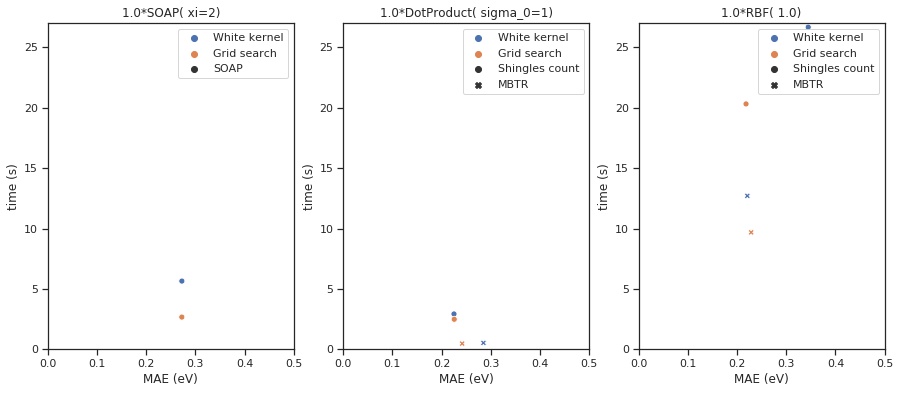

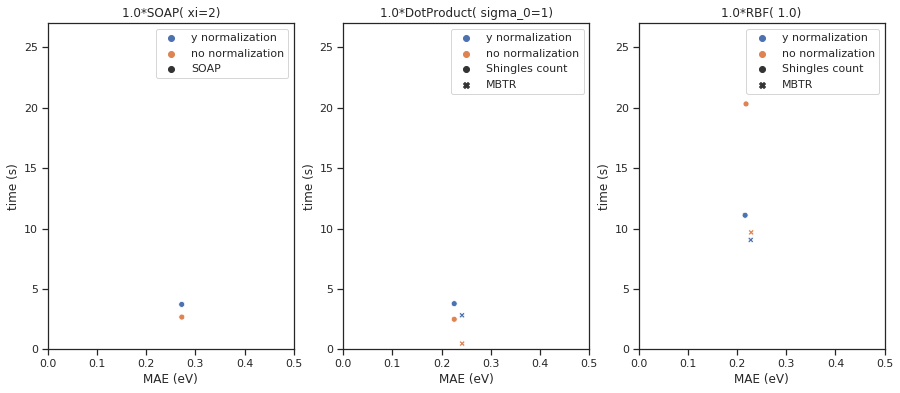

In [17]:
display_results(models, descriptors_mm, objective, output_results_path)